In [4]:
import matplotlib.pyplot as plt
import vaex
import os
import numpy as np
import pandas as pd
from helpers import *

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from helpers import *
import pandas as pd
from sklearn.linear_model import LinearRegression
pd.options.mode.chained_assignment = None  # default='warn'
## Parallel function to compute response function
from multiprocessing import Pool
import multiprocessing
from scipy.stats import wasserstein_distance
from sklearn.neighbors import KernelDensity
from fastdtw import fastdtw
from scipy.stats import ttest_ind, ranksums
import time
import seaborn as sns

### 1) Data Labelling
Assumption : a flash crash is defined as a price drop of more than 5% in a 30 minute window


In [2]:
# Data loading
current_dir  = os.getcwd()
loading_dir = os.path.join(current_dir,"data","clean", "flash_crash")
ticker_list = os.listdir(loading_dir)
if '.DS_Store' in ticker_list : ticker_list.remove('.DS_Store')
ticker_name =   ticker_list[1]
print("Ticker name: ", ticker_name)

plots_dir = os.path.join(current_dir,"plots","flash_crash",ticker_name)
file_dir = os.path.join(loading_dir,ticker_name)
file_name = os.listdir(file_dir)[0]
df = vaex.open(os.path.join(file_dir,file_name))

# Data cleaning 
df = df[ (df.index>= '2010-01-01') & (df.index<= '2010-12-31') ]

df = df.dropnan(column_names=["trade_price"])
df = df.to_pandas_df()
df.loc[:, ['bid-price', 'bid-volume','ask-price','ask-volume', ]] = df[['bid-price','bid-volume','ask-price','ask-volume']].ffill().fillna(method='bfill')
df["mid_price"] = (df["bid-price"] + df["ask-price"])/2
ny_index = pd.DatetimeIndex(df['index']) 
ny_index = ny_index.tz_localize('UTC').tz_convert('America/New_York')
df['ny_index'] = ny_index 
df.set_index('ny_index',drop=True,inplace=True)


# Data Labelling
## Label as flash crash where the drop and recovery exceed the thresholds within the window
WINDOW = '1800s' # 30 minutes
PRICE_DROP_THRESHOLD = 0.05  # 5% price drop

def max_pct_change(series):
    if len(series) < 2:
        return 0
    return ((series.max() - series) / series).max()

def min_pct_change(series):
    if len(series) < 2:
        return 0
    return ((series.min() - series) / series).min()

# Calculate the rolling max and min percentage change for the 'mid_price' column
df['max_price_pct_change'] = df['mid_price'].rolling(WINDOW).apply(max_pct_change, raw=True)
df['min_price_pct_change'] = df['mid_price'].rolling(WINDOW).apply(min_pct_change, raw=True)
df['flash_crash'] = ((df['min_price_pct_change'] <= -PRICE_DROP_THRESHOLD) & (df['max_price_pct_change'] >= PRICE_DROP_THRESHOLD) ).astype(int)

print(df.flash_crash.value_counts(normalize=True))
df[['max_price_pct_change','min_price_pct_change']].describe()
print("Without sampling, df is of length : ",len(df))
df_original = df.copy()

Ticker name:  AAPL.OQ-2010
flash_crash
0    0.992558
1    0.007442
Name: proportion, dtype: float64
Without sampling, df is of length :  5608234


### Flash Crash days inspection:

In [3]:
## Days with flash crash
df_daily_crash = df.resample('1D').agg({'flash_crash': 'sum'})
df_daily_crash[df_daily_crash['flash_crash'] > 0]    

,flash_crash
ny_index,
2010-05-06 00:00:00-04:00,11891
2010-05-07 00:00:00-04:00,9102
2010-09-28 00:00:00-04:00,8669
2010-10-19 00:00:00-04:00,12076


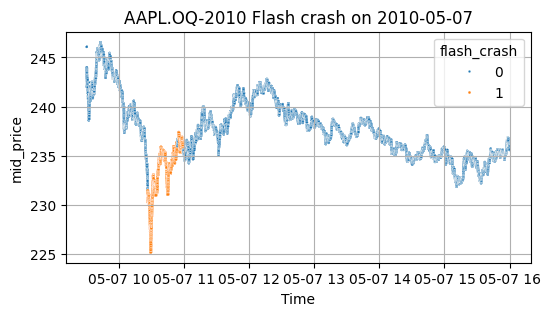

In [7]:
df  = df_original.copy()
df_crash1 = df[(df.index >= '2010-05-07')&(df.index <= '2010-05-08')]
plt.figure(figsize=(6,3))
sns.scatterplot(data=df_crash1, x=df_crash1.index, y='mid_price', hue='flash_crash',size='flash_crash',sizes=(4, 3),)
plt.title(ticker_name+ " Flash crash on 2010-05-07")
plt.xlabel('Time')
plt.grid()

### Discussion : 
As expected, we notice that the occurences of flash crashes are very rare. In fact, with our definition of a flash crash (i.e: drop >5% within 30 minute interval), we notice only 3 months where it happened and more precisely in 4 days. After careful inspection, the first one is the famous big flash crash, the second one is on the day just after and the last two are actually just price redress at market opening.

In [67]:
# Percentage of flash crash labels in flash crash period
df_original[(df_original.index >= '2010-05-06') & (df_original.index <= '2010-05-08')].flash_crash.value_counts(normalize=True)

flash_crash
0    0.799068
1    0.200932
Name: proportion, dtype: float64

In [8]:
## Group trades into minutes by taking sum of trade volume, mean price.. and label as flash crash if the number of trades exceed the threshold within the window
df_resampled = df.copy()
df_resampled =  df_resampled[ (df_resampled.index >= '2010-05-06') & (df_resampled.index <= '2010-05-07')]
df_resampled = df_resampled.resample('1s').agg({'trade_price': 'mean', 'trade_volume': 'sum', 'ask-price': 'mean', 'bid-price': 'mean', 'ask-volume': 'sum', 'bid-volume': 'sum', 'mid_price': 'mean', 'max_price_pct_change': 'max', 'min_price_pct_change': 'min', 'flash_crash': 'max'})
df_resampled.dropna(inplace=True)
print(df_resampled.flash_crash.value_counts(normalize=True))
print(df_resampled[['max_price_pct_change','min_price_pct_change']].describe())
df = df_resampled.copy()

flash_crash
0.0    0.832337
1.0    0.167663
Name: proportion, dtype: float64
       max_price_pct_change  min_price_pct_change
count          12883.000000          12883.000000
mean               0.048328             -0.041524
std                0.077736              0.061754
min                0.004639             -0.202884
25%                0.008907             -0.038421
50%                0.012529             -0.012374
75%                0.039956             -0.008829
max                0.254523             -0.004618


#### 2) Training 
Note: Training should be done on a rolling calibration.
We cannot just perform a logistic regresssion because the flash crash actually only happens a few times so with a rolling callibration, we will mostly have one class (0: non flash crash). We can either try to label our data with a probability of crash but this needs very stong assumptions about price volatility and other metrics. Or the method we will be implementing is using the market response function. First we need a regression on a the response function, then a classification using a simple model (exceeding a magnitude threshold in values/spread)

Note: We need to use F1 score since the data is very imbalanced.

#### a) Naive approach : Use Mean squared error as loss function

In [33]:
def compute_deviation(y_pred, y_true):
    return ((y_pred - y_true)**2).mean()

# Parameters
k = 2000  # Window size
tau_max = k # should be equal to k
threshold = 0.8  # Threshold for deviation
num_cores = multiprocessing.cpu_count()
# Initialize model
model = LinearRegression()
metrics  ={"TP":0,"TN":0,"FP":0,"FN":0}
y_pred_list = []
deviation_list = []
total_deviation_list = []
deviation_nb_threshold = 50
nb_plots = 10

# Fit and predict in a rolling window
for i in range(k, len(df)-1):
    start_time = time.time()
    # Fit the model on the window from t to t+k
    X_train = df[i-k:i]
    X_train.reset_index(inplace=True)
    X_train = setup_response_function_data(X_train)     # Response function
    X_train.drop(columns=['flash_crash'],inplace=True)
    X_train.set_index('ny_index',drop=True,inplace=True)
    y_train = list(compute_response_c(X_train,tau_max))      # Response function
    y_train.insert(0,0) # Response function at tau = 0 is 0 because price change is 0
    if not df[i-k:i].flash_crash.sum():
        model.fit(X_train, y_train)
    
    
    y_pred = model.predict(X_train)
    # Calculate deviation
    deviation = compute_deviation(y_pred, y_train)
    total_deviation_list.append(deviation)
    if not df[i-k:i].flash_crash.sum():
        deviation_list.append(deviation)
    flash_crash = check_flash_crash(deviation,threshold) 
    metrics = update_metrics(metrics,flash_crash, df.iloc[i+1].flash_crash)

    y_pred_list.append(flash_crash )
    end_time = time.time()
    # Check for flash crash
    print('*'*50)
    print("At time",df.index[i+1])
    print( f"flash crash: predicted: {bool(flash_crash)}, actual : {bool(df.iloc[i+1].flash_crash)} ") 
    # print(f"Time taken: {end_time-start_time}")
    print(f"Deviation :     {deviation}")
    # print(f"Metrices: {metrics}")
    # print(f"F1 score: {f1_score(metrics)}, Accuracy: {accuracy(metrics)}")
    predicted_flash_crash = False
    if len(deviation_list) >= deviation_nb_threshold:
        window_deviation = np.mean(deviation_list[-deviation_nb_threshold:])
        print("Deviation mean",window_deviation)
        predicted_flash_crash = abs(deviation - window_deviation)  > abs(2* window_deviation)
    else :
        predicted_flash_crash = deviation > threshold
    
    if predicted_flash_crash:
        print(f"{bool(df.iloc[i+1].flash_crash)} Flash crash predicted at time {df.index[i+1]}")
        if nb_plots > 0:
            nb_plots -= 1    
            plt.plot(y_pred, label= 'Predicted response')
            plt.plot(y_train, label= 'Actual response')
            plt.legend()
            plt.show()
            

KeyError: "None of ['index'] are in the columns"

#### b) Dynamic Time Warping (DTW):
DTW is a technique for measuring the similarity between two sequences, even when they have different lengths or are temporally misaligned. So we can use this function even when window and tau max are not equal

In [32]:
def compute_deviation(y_pred, y_true):
    distance, _ = fastdtw(y_true, y_pred)
    return distance

# Parameters
k = 2000  # Window size
tau_max = k # should be equal to k
threshold = 100  # Threshold for deviation
num_cores = multiprocessing.cpu_count()
# Initialize model
model = LinearRegression()
metrics  ={"TP":0,"TN":0,"FP":0,"FN":0}
y_pred_list = []
deviation_list = []
total_deviation_list = []
deviation_nb_threshold = 50
nb_plots = 10
# Fit and predict in a rolling window
for i in range(k, len(df)-1):
    start_time = time.time()
    # Fit the model on the window from t to t+k
    X_train = df[i-k:i]
    X_train = setup_response_function_data(X_train)     # Response function
    X_train.drop(columns=['prev_mid_price','prev_trade','flash_crash'],inplace=True)

    y_train = list(compute_response_c(X_train,tau_max))      # Response function
    y_train.insert(0,0) # Response function at tau = 0 is 0 because price change is 0
    if not df[i-k:i].flash_crash.sum():
        model.fit(X_train, y_train)
    
    
    y_pred = model.predict(X_train)
    # Calculate deviation
    deviation = compute_deviation(y_pred, y_train)
    total_deviation_list.append(deviation)
    if not df[i-k:i].flash_crash.sum():
        deviation_list.append(deviation)
    flash_crash = check_flash_crash(deviation,threshold) 
    metrics = update_metrics(metrics,flash_crash, df.iloc[i+1].flash_crash)

    y_pred_list.append(flash_crash )
    end_time = time.time()
    # Check for flash crash
    print("At time",df.index[i+1])
    print( f"flash crash: predicted: {bool(flash_crash)}, actual : {bool(df.iloc[i+1].flash_crash)} ") 
    print(f"Time taken: {end_time-start_time}")
    print(f"Deviation : {deviation}")
    # print(f"Metrices: {metrics}")
    # print(f"F1 score: {f1_score(metrics)}, Accuracy: {accuracy(metrics)}")
    predicted_flash_crash = False
    if len(deviation_list) >= deviation_nb_threshold:
        window_deviation = np.mean(deviation_list[-deviation_nb_threshold:])
        print("Deviation mean",window_deviation)
        predicted_flash_crash = abs(deviation - window_deviation)  > abs(2* window_deviation)
    else :
        predicted_flash_crash = deviation > threshold
    
    if predicted_flash_crash:
        print(f"{bool(df.iloc[i+1].flash_crash)} Flash crash predicted at time {df.index[i+1]}")
        if nb_plots > 0:
            nb_plots -= 1    
            plt.plot(y_pred, label= 'Predicted response')
            plt.plot(y_train, label= 'Actual response')
            plt.legend()
            plt.show()
            

At time 2010-05-06 10:29:19-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.4489870071411133
Deviation : 62.96896427414745
At time 2010-05-06 10:29:27-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.4454529285430908
Deviation : 58.57173628348042
At time 2010-05-06 10:29:29-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.4421062469482422
Deviation : 56.79753374351739
At time 2010-05-06 10:29:30-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.4431571960449219
Deviation : 55.01203528665147
At time 2010-05-06 10:29:31-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.433912992477417
Deviation : 53.35378818814195
At time 2010-05-06 10:29:32-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.4333021640777588
Deviation : 56.08694453180067
At time 2010-05-06 10:29:33-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.4343721866607666
Deviation : 60.32963484850605
At time

Traceback (most recent call last):
  File "/Users/yacine/tensorflow-test/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/xc/fqhfbxxx7yb4n__mj0cc0wvc0000gn/T/ipykernel_82331/37721660.py", line 26, in <module>
    y_train = list(compute_response_c(X_train,tau_max))      # Response function
  File "/Users/yacine/Desktop/Flash_crash/helpers.py", line 667, in compute_response_c
    return R[:tau_max-1]
  File "/Users/yacine/tensorflow-test/env/lib/python3.8/site-packages/scipy/signal/_signaltools.py", line 669, in fftconvolve
    ret = _freq_domain_conv(in1, in2, axes, shape, calc_fast_len=True)
  File "/Users/yacine/tensorflow-test/env/lib/python3.8/site-packages/scipy/signal/_signaltools.py", line 509, in _freq_domain_conv
    ret = ifft(sp1 * sp2, fshape, axes=axes)
  File "/Users/yacine/tensorflow-test/env/lib/python3.8/site-packages/scipy/fft/_backend.py", line 25, in __

#### c) Kernel Density Estimation (KDE)

In [34]:

def compute_deviation_wasserstein(y_pred, y_true):
    # Assuming actual_response and predicted_response are your time series data
    kde_actual = KernelDensity(kernel='gaussian').fit(np.array(y_true).reshape(-1, 1))
    kde_predicted = KernelDensity(kernel='gaussian').fit(np.array(y_pred).reshape(-1, 1))
    # Evaluate the estimated density functions on a grid
    x_grid = np.linspace(min(min(y_true), min(y_pred)),
                        max(max(y_true), max(y_pred)), 1000)
    log_density_actual = kde_actual.score_samples(x_grid.reshape(-1, 1))
    log_density_predicted = kde_predicted.score_samples(x_grid.reshape(-1, 1))
    # Calculate the Wasserstein distance between the two estimated distributions
    distance = wasserstein_distance(np.exp(log_density_actual), np.exp(log_density_predicted))
    return distance

# Parameters
k = 2000  # Window size
tau_max = k # should be equal to k
threshold = 0.01  # Threshold for deviation
num_cores = multiprocessing.cpu_count()
# Initialize model
model = LinearRegression()
metrics  ={"TP":0,"TN":0,"FP":0,"FN":0}
y_pred_list = []
deviation_list = []
total_deviation_list = []
deviation_nb_threshold = 50
nb_plots = 10
# Fit and predict in a rolling window
for i in range(k, len(df)-1):
    start_time = time.time()
    # Fit the model on the window from t to t+k
    X_train = df[i-k:i]
    X_train = setup_response_function_data(X_train)     # Response function
    X_train.drop(columns=['prev_mid_price','prev_trade','flash_crash'],inplace=True)

    y_train = list(compute_response_c(X_train,tau_max))      # Response function
    y_train.insert(0,0) # Response function at tau = 0 is 0 because price change is 0
    if not df[i-k:i].flash_crash.sum():
        model.fit(X_train, y_train)
    
    
    y_pred = model.predict(X_train)
    # Calculate deviation
    deviation = compute_deviation_wasserstein(y_pred, y_train)
    total_deviation_list.append(deviation)
    if not df[i-k:i].flash_crash.sum():
        deviation_list.append(deviation)
    flash_crash = check_flash_crash(deviation,threshold) 
    metrics = update_metrics(metrics,flash_crash, df.iloc[i+1].flash_crash)

    y_pred_list.append(flash_crash )
    end_time = time.time()
    # Check for flash crash
    print("At time",df.index[i+1])
    print( f"flash crash: predicted: {bool(flash_crash)}, actual : {bool(df.iloc[i+1].flash_crash)} ") 
    print(f"Time taken: {end_time-start_time}")
    print(f"Deviation :     {deviation}")
    # print(f"Metrices: {metrics}")
    # print(f"F1 score: {f1_score(metrics)}, Accuracy: {accuracy(metrics)}")
    predicted_flash_crash = False
    if len(deviation_list) >= deviation_nb_threshold:
        window_deviation = np.mean(deviation_list[-deviation_nb_threshold:])
        print("Deviation mean",window_deviation)
        predicted_flash_crash = abs(deviation - window_deviation)  > abs(2* window_deviation)
    else :
        predicted_flash_crash = deviation > threshold
    
    if predicted_flash_crash:
        print(f"{bool(df.iloc[i+1].flash_crash)} Flash crash predicted at time {df.index[i+1]}")
        if nb_plots > 0:
            nb_plots -= 1    
            plt.plot(y_pred, label= 'Predicted response')
            plt.plot(y_train, label= 'Actual response')
            plt.legend()
            plt.show()
            

KeyError: 0

#### d) Analytical observations from the response function
- Magnitude of the Response Function
- Volatility of the Response Function
- Stability of the Response Function

In [25]:
def compute_deviation(y_pred, y_true , weight_ttest=0.5,  weight_stability=0.5 ):
    # Response magnitude
    _, p_value_t = ttest_ind(y_pred, y_true,alternative='less',equal_var=False)
    _, p_value_u = ranksums(y_pred, y_true,alternative='less')

    # Calculate the coefficient of variation (CV)
    cv_true = np.std(y_true) / np.mean(y_true)
    cv_pred = np.std(y_pred) / np.mean(y_pred)
    if cv_true>cv_pred:
        deviation_stability = ((cv_true-cv_pred)/ cv_true)
    else:
        deviation_stability = ((cv_pred-cv_true)/ cv_pred)

    overall_deviation = (2-p_value_t-p_value_u)/2 * weight_ttest + deviation_stability*weight_stability
    return overall_deviation

In [26]:
def setup_response_function_data(df):
    """ Setup the data for the response function analysis. 
    If not found,Compute the mid-price, previous mid-price,pervious trade price and the trade class.
    """
    if not isinstance(df, pd.DataFrame): df = df.to_pandas_df()
    assert set( ['trade_price', 'trade_volume', 'bid-price', 'bid-volume', 'ask-price', 'ask-volume'] ).issubset(set(df.columns.tolist()))
    # Fill the missing values in the bid and ask price 
    df.loc[:, ['bid-price','ask-price']] = df[['bid-price','ask-price']].ffill()
    # Compute the mid price
    if 'mid_price' not in df.columns: df['mid_price'] = (df['ask-price'] + df['bid-price']) / 2
    df.reset_index(inplace=True)
    
    if 'trade_class' not in df.columns: 
        df['trade_class'] = np.nan
        for i in range(len(df)):
            if not pd.isna(df.at[i, 'trade_price']):
                tradeclass(i,df) 
    df.dropna(subset=["trade_class"] , inplace=True)

    # Set the index to be the timestamp
    if type(df.index) != pd.DatetimeIndex: 
        if 'index' in df.columns :
            df.set_index('index',inplace=True)
        else:
            df.set_index('ny_index',inplace=True)
    # Convert the index to New York timezone
    if str(df.index.tzinfo) != 'America/New_York':
        ny_index = pd.DatetimeIndex(df['index']) if 'index' in df.columns else pd.DatetimeIndex(df.index)
        ny_index = ny_index.tz_localize('UTC').tz_convert('America/New_York')
        df.loc[:, 'index'] = ny_index
        df.set_index('index',inplace=True)
    return df


**************************************************
At time 2010-05-06 13:17:14-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.21462225914001465
Deviation : 0.43813212889024
**************************************************
At time 2010-05-06 13:17:17-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.19181013107299805
Deviation : 0.4913932300408608
**************************************************
At time 2010-05-06 13:17:18-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.1928088665008545
Deviation : 0.5395729751216949
**************************************************
At time 2010-05-06 13:17:19-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.19338321685791016
Deviation : 0.7638229442018141
**************************************************
At time 2010-05-06 13:17:20-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.19491004943847656
Deviation : 0.7825021536245864
****************************

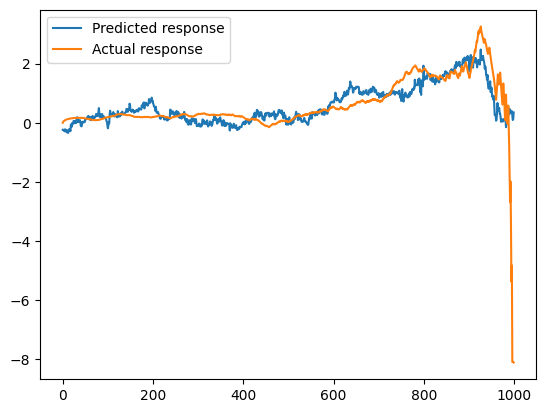

Deviation mean 0.260118828565293
**************************************************
At time 2010-05-06 14:38:58-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.19511127471923828
Deviation : 0.37728005071784065
Deviation mean 0.2705925580225757
**************************************************
At time 2010-05-06 14:38:59-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.1851792335510254
Deviation : 0.28681980958502695
Deviation mean 0.270749295464041
**************************************************
At time 2010-05-06 14:39:00-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.18495988845825195
Deviation : 0.20764159921947895
Deviation mean 0.267549311485395
**************************************************
At time 2010-05-06 14:39:01-04:00
flash crash: predicted: False, actual : False 
Time taken: 0.18518400192260742
Deviation : 0.16346411736847788
Deviation mean 0.26729867856763206
*************************************************

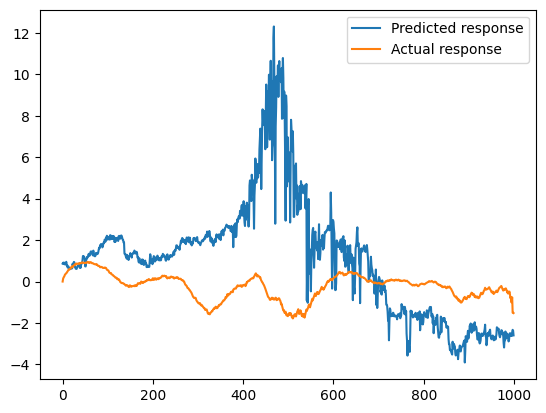

Deviation mean 0.49974230721215873
**************************************************
At time 2010-05-06 14:55:46-04:00
flash crash: predicted: True, actual : True 
Time taken: 0.18835186958312988
Deviation : 1.025220309406912
True Flash crash predicted at time 2010-05-06 14:55:46-04:00


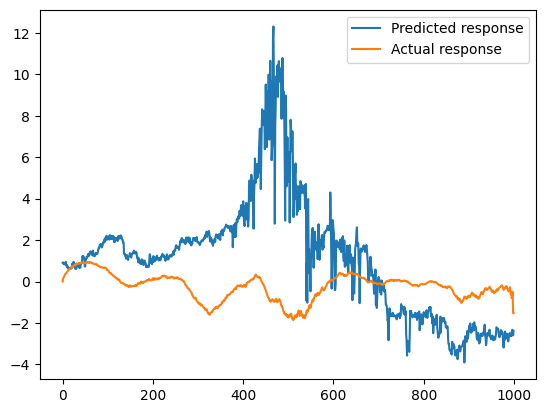

Deviation mean 0.49974230721215873
**************************************************
At time 2010-05-06 14:55:47-04:00
flash crash: predicted: True, actual : True 
Time taken: 0.19184470176696777
Deviation : 1.042874631061114
True Flash crash predicted at time 2010-05-06 14:55:47-04:00


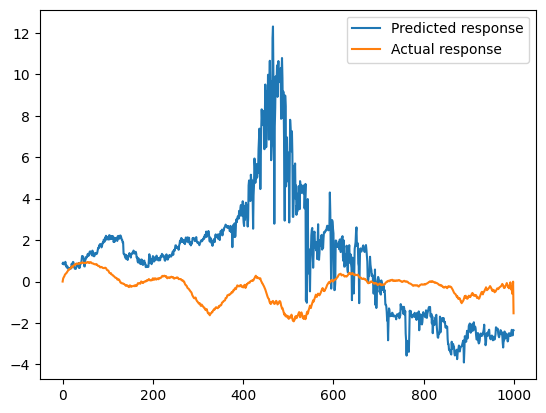

Deviation mean 0.49974230721215873
**************************************************
At time 2010-05-06 14:55:48-04:00
flash crash: predicted: True, actual : True 
Time taken: 0.18545079231262207
Deviation : 1.0523704980016717
True Flash crash predicted at time 2010-05-06 14:55:48-04:00


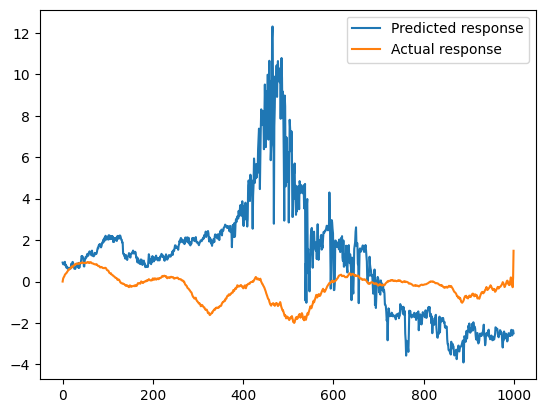

Deviation mean 0.49974230721215873
**************************************************
At time 2010-05-06 14:55:49-04:00
flash crash: predicted: True, actual : True 
Time taken: 0.18812298774719238
Deviation : 1.0616956409338094
True Flash crash predicted at time 2010-05-06 14:55:49-04:00


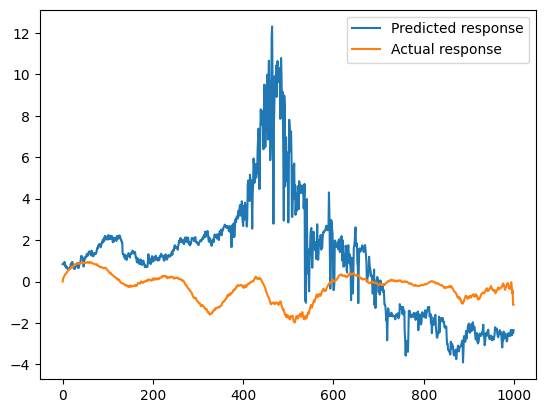

Deviation mean 0.49974230721215873
**************************************************
At time 2010-05-06 14:55:50-04:00
flash crash: predicted: True, actual : True 
Time taken: 0.1890871524810791
Deviation : 1.0814672206161835
True Flash crash predicted at time 2010-05-06 14:55:50-04:00


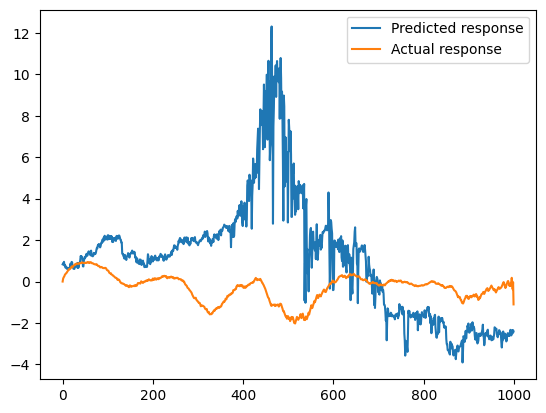

Deviation mean 0.49974230721215873
**************************************************
At time 2010-05-06 14:55:51-04:00
flash crash: predicted: True, actual : True 
Time taken: 0.19497203826904297
Deviation : 1.0949706981272056
True Flash crash predicted at time 2010-05-06 14:55:51-04:00


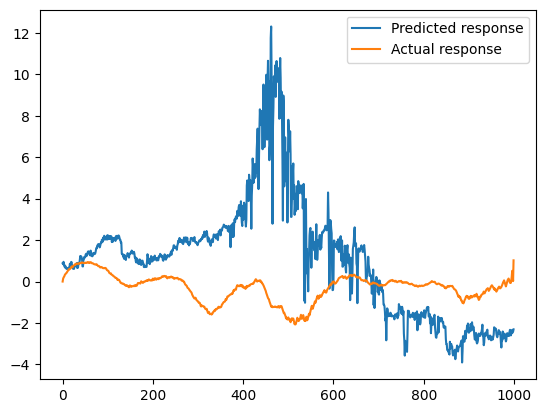

Deviation mean 0.49974230721215873
**************************************************
At time 2010-05-06 14:55:52-04:00
flash crash: predicted: True, actual : True 
Time taken: 0.18711400032043457
Deviation : 1.097455711367195
True Flash crash predicted at time 2010-05-06 14:55:52-04:00


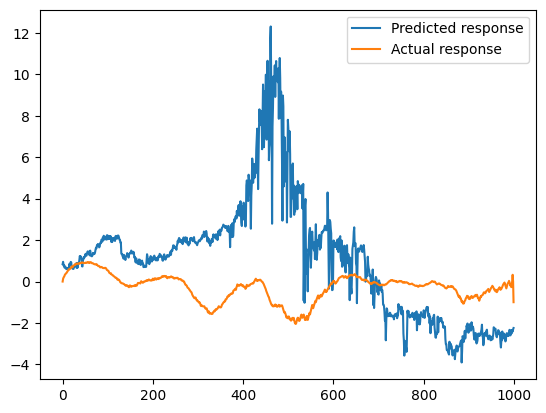

Deviation mean 0.49974230721215873
**************************************************
At time 2010-05-06 14:55:53-04:00
flash crash: predicted: True, actual : True 
Time taken: 0.19126105308532715
Deviation : 1.111884872619625
True Flash crash predicted at time 2010-05-06 14:55:53-04:00


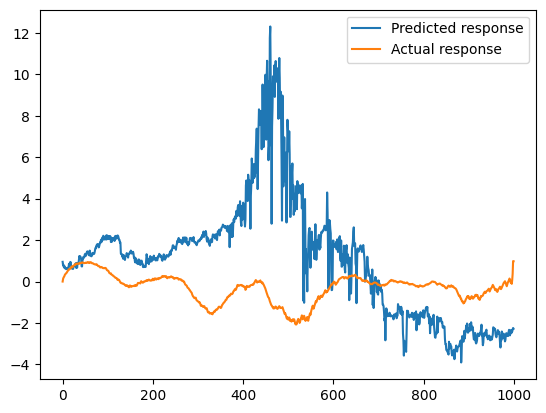

Deviation mean 0.49974230721215873
**************************************************
At time 2010-05-06 14:55:54-04:00
flash crash: predicted: True, actual : True 
Time taken: 0.2021958827972412
Deviation : 1.1123919450330115
True Flash crash predicted at time 2010-05-06 14:55:54-04:00
Deviation mean 0.49974230721215873
**************************************************
At time 2010-05-06 14:55:56-04:00
flash crash: predicted: True, actual : True 
Time taken: 0.17931079864501953
Deviation : 1.1119786749783258
True Flash crash predicted at time 2010-05-06 14:55:56-04:00
Deviation mean 0.49974230721215873
**************************************************
At time 2010-05-06 14:55:57-04:00
flash crash: predicted: True, actual : True 
Time taken: 0.1879899501800537
Deviation : 1.1355597343014328
True Flash crash predicted at time 2010-05-06 14:55:57-04:00
Deviation mean 0.49974230721215873
**************************************************
At time 2010-05-06 14:55:58-04:00
flash crash: pr

In [13]:
# Parameters
k = 1000  # Window size
tau_max = k # should be equal to k
threshold = 0.9  # Threshold for deviation
# Initialize model
df = df[ (df.index>= '2010-05-06 12:30') & (df.index<= '2010-05-08') ]
model = LinearRegression()

metrics  ={"TP":0,"TN":0,"FP":0,"FN":0}
y_pred_list = []
deviation_list = []
total_deviation_list = []
deviation_nb_threshold = 10
nb_plots = 10
# Fit and predict in a rolling window
for i in range(k, len(df)-1):
    start_time = time.time()
    # Fit the model on the window from t to t+k
    X_train = df[i-k:i]
    X_train = setup_response_function_data(X_train)     # Response function
    X_train.drop(columns=['flash_crash'],inplace=True)
    y_train = list(compute_response_c(X_train,tau_max))      # Response function
    y_train.insert(0,0) # Response function at tau = 0 is 0 because price change is 0
    if not df[i-k:i].flash_crash.sum():
        model.fit(X_train, y_train)
    
    y_pred = model.predict(X_train)
    deviation = compute_deviation(y_pred, y_train)
    total_deviation_list.append(deviation)
    if not df[i-k:i].flash_crash.sum():
        deviation_list.append(deviation)

    predicted_flash_crash = False
    if len(deviation_list) >= deviation_nb_threshold:
        window_deviation = np.mean(deviation_list[-deviation_nb_threshold:])
        print("Deviation mean",window_deviation)
        predicted_flash_crash = abs(deviation)  > 2* abs(window_deviation)
    else :
        predicted_flash_crash = deviation > threshold

    metrics = update_metrics(metrics,predicted_flash_crash, df.iloc[i+1].flash_crash)
    y_pred_list.append(predicted_flash_crash )
    end_time = time.time()

    # Check for flash crash
    print('*'*50)
    print("At time",df.index[i+1])
    print( f"flash crash: predicted: {bool(predicted_flash_crash)}, actual : {bool(df.iloc[i+1].flash_crash)} ") 
    print(f"Time taken: {end_time-start_time}")
    print(f"Deviation : {deviation}")
    
    if predicted_flash_crash:
        print(f"{bool(df.iloc[i+1].flash_crash)} Flash crash predicted at time {df.index[i+1]}")
        if nb_plots > 0:
            nb_plots -= 1    
            plt.plot(y_pred, label= 'Predicted response')
            plt.plot(y_train, label= 'Actual response')
            plt.legend()
            plt.show()
            

In [14]:
metrics

{'TP': 955, 'TN': 3921, 'FP': 662, 'FN': 1205}

In [15]:
f1_score(metrics), accuracy(metrics)

(0.5056923484246757, 0.7231202728755747)

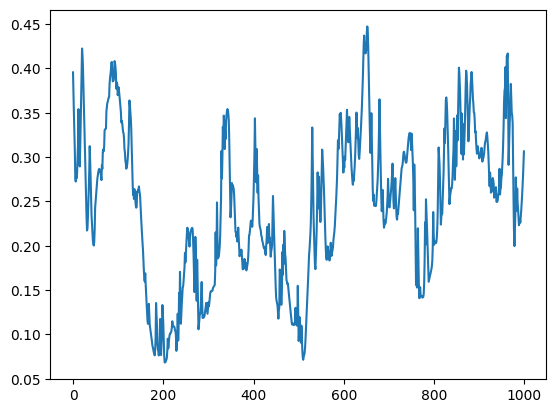

In [115]:
plt.plot(total_deviation_list[:1000])

In [116]:
metrics

{'TP': 874, 'TN': 169328, 'FP': 1072, 'FN': 2867}

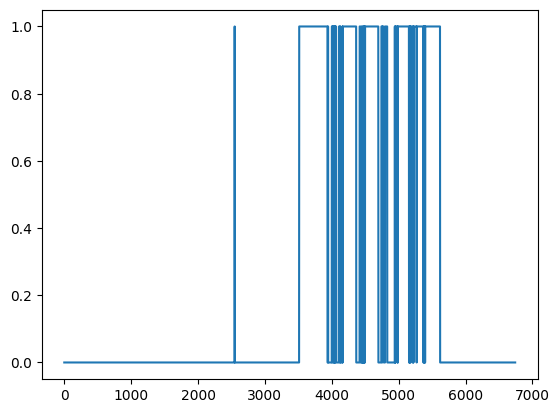

In [23]:
plt.plot( y_pred_list)